In [25]:
# FEMA Public Assistance Data Analysis

import pandas as pd
import numpy as np
import urllib.request
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [26]:
# Load Data from FEMA API

def load_fema_data(url, name, max_records=50000):
    """Load data from FEMA API with pagination"""
    try:
        full_url = f"{url}?$top={max_records}"
        with urllib.request.urlopen(full_url, timeout=120) as response:
            data = json.loads(response.read().decode())
        keys = [k for k in data.keys() if k not in ['metadata']]
        if keys:
            df = pd.DataFrame(data[keys[0]])
            print(f"{name}: {len(df):,} records")
            return df
        return pd.DataFrame()
    except Exception as e:
        print(f"{name}: Error - {str(e)[:50]}")
        return pd.DataFrame()

datasets = {}
datasets['applicants'] = load_fema_data("https://www.fema.gov/api/open/v1/PublicAssistanceApplicants", "Applicants")
datasets['deliveries'] = load_fema_data("https://www.fema.gov/api/open/v1/PublicAssistanceApplicantsProgramDeliveries", "Deliveries")
datasets['projects_details'] = load_fema_data("https://www.fema.gov/api/open/v2/PublicAssistanceFundedProjectsDetails", "Projects Details")
datasets['projects_summary'] = load_fema_data("https://www.fema.gov/api/open/v1/PublicAssistanceFundedProjectsSummaries", "Projects Summary")
datasets['grants'] = load_fema_data("https://www.fema.gov/api/open/v2/PublicAssistanceGrantAwardActivities", "Grants")
datasets['appeals'] = load_fema_data("https://www.fema.gov/api/open/v1/PublicAssistanceSecondAppealsTracker", "Appeals")

Applicants: 50,000 records
Deliveries: 50,000 records
Deliveries: 50,000 records
Projects Details: 50,000 records
Projects Details: 50,000 records
Projects Summary: 50,000 records
Projects Summary: 50,000 records
Grants: 50,000 records
Grants: 50,000 records
Appeals: 1,559 records
Appeals: 1,559 records


In [27]:
# Dataset Overview

for name, df in datasets.items():
    if len(df) > 0:
        print(f"\n{name.upper()}: {df.shape}")
        display(df.head(2))


APPLICANTS: (50000, 11)


,disasterNumber,applicantId,state,applicantName,addressLine1,addressLine2,city,zipCode,hash,lastRefresh,id
0,1247,000-92146,Puerto Rico,JUVENILE INSTITUTIONS ADMINISTRATION,60 BOLIVIA & CHILE ST.,None,None,00917,a054428d55310fadee31e1e3a665c87026955afb,2025-12-09T15:03:51.184Z,718634e4-420b-4a20-9b94-9ad5ad60c395
1,1247,127-90741,Puerto Rico,HOGARES RAFAEL IBARRA,"TORRELAGUNA 432, SAN JOSE, RIO PIEDRAS",None,None,00923,6837282232d7e2073152d026558649ba63d09c61,2025-12-09T15:03:51.184Z,3d6f98ce-4bba-4aea-a950-fb20bfdde2c8



DELIVERIES: (50000, 35)


,declarationType,disasterNumber,stateCode,stateName,declarationDate,incidentType,declarationTitle,region,consolidatedResourceCenter,countyApplicantJurisdiction,...,phase3ProjectCost,numberPhase4Projects,phase4ProjectCost,numberPhase5Projects,phase5ProjectCost,numberObligatedProjects,federalShareObligated,hash,lastRefresh,id
0,DR,4284,GA,Georgia,2016-10-09T00:00:00.000Z,Hurricane,Hurricane Matthew,4,Central,Chatham County,...,0.0,0,0.0,13,28141560.32,13,22990161.95,17145d144df1997fdf0ddbb6a20756b16d421560,2025-05-22T15:06:07.420Z,a0f6d7a2-e2e2-4e82-b5d0-7d4b4f99de77
1,DR,4332,TX,Texas,2017-08-25T00:00:00.000Z,Hurricane,Hurricane Harvey,6,Central,Harris County,...,0.0,0,0.0,3,46412.00,2,41770.80,fc78f68048e4196b1b8647605fdd0ed5092ea1de,2025-07-22T15:04:36.671Z,fd9ce282-6808-47d4-95de-9999ba54b436



PROJECTS_DETAILS: (50000, 25)


,disasterNumber,declarationDate,incidentType,pwNumber,applicationTitle,applicantId,damageCategoryCode,damageCategoryDescrip,projectStatus,projectProcessStep,...,projectAmount,federalShareObligated,totalObligated,lastObligationDate,firstObligationDate,mitigationAmount,gmProjectId,gmApplicantId,lastRefresh,hash
0,1239,1998-08-26T00:00:00.000Z,Severe Storm(s),1,(PW# 1) IMMEDIATE NEEDS FUNDING,465-19792-00,B,Emergency Protective Measures,Active,Project Closed Out,...,100000.0,75000.00,80340.0,1998-09-15T14:25:07.000Z,1998-09-15T14:25:07.000Z,0.0,1021769,268458,2025-11-27T15:05:59.253Z,addcfded82ae348f46ff034a4564f983a9dea897
1,1239,1998-08-26T00:00:00.000Z,Severe Storm(s),5,(PW# 5) Not Provided,465-19792-00,G,"Parks, Recreational Facilities, and Other Items",Active,Project Closed Out,...,19685.5,14764.13,15461.0,1998-09-23T08:58:52.000Z,1998-09-23T08:58:52.000Z,0.0,1062596,268458,2025-11-27T15:05:59.253Z,05c6c522b930a9c38b52a0c4b0de853e98b4cb75



PROJECTS_SUMMARY: (50000, 12)


,disasterNumber,declarationDate,incidentType,state,county,applicantName,educationApplicant,numberOfProjects,federalObligatedAmount,lastRefresh,hash,id
0,4117,2013-05-20T00:00:00.000Z,Tornado,Oklahoma,Canadian County,PIEDMONT,False,3,18789.74,2025-11-27T15:02:55.300Z,6735e166e19e26665c02c011f0165726d99ec03b,962b7870-12a3-4cd6-8427-23fcd3a47342
1,4480,2020-03-20T00:00:00.000Z,Biological,New York,Ontario County,"Victor Farmington Volunteer Ambulance Corps, Inc.",False,5,38048.44,2025-11-06T15:02:02.841Z,09b5497832dd9a36519c3823459ee028b08afa58,cf13abf5-8af5-41d1-8101-466711ac6fad



GRANTS: (50000, 23)


,region,disasterNumber,sriaDisaster,declarationTitle,disasterType,incidentType,declarationDate,stateAbbreviation,state,county,...,damageCategoryCode,federalShareObligated,dateObligated,pwNumber,projectTitle,versionNumber,eligibilityStatus,fundingStatus,paCloseoutStatus,id
0,3,1455,False,"SEVERE WINTER STORM, RECORD/NEAR RECORD SNOW, ...",DR,Severe Storm,2003-03-14T00:00:00.000Z,WV,West Virginia,Statewide,...,C - Roads and Bridges,2745.68,2003-08-28T00:00:00.000Z,809,"ROADS, NON ER CR 10/53, POSEY ENGLAND RD, WYO...",0,E,O,C,6de7e36a-8fe6-490f-9c4c-70a81d34915a
1,2,1993,False,"SEVERE STORMS, FLOODING, TORNADOES, AND STRAIG...",DR,Flood,2011-06-10T00:00:00.000Z,NY,New York,Clinton,...,B - Protective Measures,1942.97,2011-11-10T00:00:00.000Z,1457,5857404 - Municipal Lighting Department,0,E,O,C,b6b9aea1-0ee6-4573-97fa-363b82594faf



APPEALS: (1559, 15)


,region,disasterNumber,declarationType,recipient,appellant,applicantId,pwgmpNumber,status,hqReceivedDate,emailAcknowledgementDate,rfiSentDate,rfiDueDate,rfiReceivedDate,decisionSignedDate,id
0,9,1952,DR,CA,South San Luis Obispo County Sanitation District,079-UT3EJ-00,"272, 792, 793",Partially Granted,2013-09-12T00:00:00.000Z,None,2014-01-30T00:00:00.000Z,2014-02-28T00:00:00.000Z,2014-02-27T00:00:00.000Z,2015-11-30T00:00:00.000Z,1151843
1,4,1909,DR,TN,Nashville-Davidson County,037-52004-00,5593,Granted,2014-02-04T00:00:00.000Z,None,2014-05-22T00:00:00.000Z,2014-06-22T00:00:00.000Z,2014-06-20T00:00:00.000Z,2015-09-25T00:00:00.000Z,1151844


In [28]:
# Identify Monetary Columns

for name, df in datasets.items():
    if len(df) > 0:
        monetary_cols = [col for col in df.columns if any(x in col.lower() for x in 
                        ['amount', 'cost', 'obligated', 'federal', 'share', 'funding'])]
        if monetary_cols:
            print(f"\n{name}: {monetary_cols}")


deliveries: ['totalAppDamageCost', 'currentProjectCost', 'phase2ProjectCost', 'phase3ProjectCost', 'phase4ProjectCost', 'phase5ProjectCost', 'numberObligatedProjects', 'federalShareObligated']

projects_details: ['projectAmount', 'federalShareObligated', 'totalObligated', 'mitigationAmount']

projects_summary: ['federalObligatedAmount']

grants: ['federalShareObligated', 'dateObligated', 'fundingStatus']


In [29]:
# Prepare Deliveries Dataset for Modeling

df = datasets['deliveries'].copy()
df_model = df[df['federalShareObligated'] > 0].copy()

print(f"Records: {len(df_model):,}")
print(f"Target Mean: ${df_model['federalShareObligated'].mean():,.2f}")
print(f"Total: ${df_model['federalShareObligated'].sum()/1e9:.2f}B")
print(f"\nTop Incident Types:\n{df_model['incidentType'].value_counts().head(5)}")

Records: 25,369
Target Mean: $3,068,224.58
Total: $77.84B

Top Incident Types:
incidentType
Biological         6634
Severe Storm(s)    5632
Hurricane          5281
Flood              2122
Other              1749
Name: count, dtype: int64


In [30]:
# Feature Engineering

df_eng = df_model.copy()

# Region mapping
region_names = {1: 'Northeast', 2: 'Northeast', 3: 'Mid-Atlantic', 4: 'Southeast',
                5: 'Midwest', 6: 'South Central', 7: 'Central', 8: 'Mountain',
                9: 'Pacific', 10: 'Pacific Northwest'}
df_eng['region_name'] = df_eng['region'].map(region_names).fillna('Other')

# Project phase distribution
total_projects = (df_eng['numberPhase2Projects'] + df_eng['numberPhase3Projects'] + 
                  df_eng['numberPhase4Projects'] + df_eng['numberPhase5Projects']).replace(0, 1)
for i in range(2, 6):
    df_eng[f'pct_phase{i}'] = df_eng[f'numberPhase{i}Projects'] / total_projects

# Cost phase distribution  
total_cost = (df_eng['phase2ProjectCost'] + df_eng['phase3ProjectCost'] + 
              df_eng['phase4ProjectCost'] + df_eng['phase5ProjectCost']).replace(0, 1)
for i in range(2, 6):
    df_eng[f'pct_cost_phase{i}'] = df_eng[f'phase{i}ProjectCost'] / total_cost

# Efficiency metrics
df_eng['cost_per_project'] = np.where(df_eng['numberObligatedProjects'] > 0,
    df_eng['federalShareObligated'] / df_eng['numberObligatedProjects'], 0)
df_eng['damage_to_cost_ratio'] = np.where(df_eng['currentProjectCost'] > 0,
    df_eng['totalAppDamageCost'] / df_eng['currentProjectCost'], 0)
df_eng['federal_share_pct'] = np.where(df_eng['currentProjectCost'] > 0,
    df_eng['federalShareObligated'] / df_eng['currentProjectCost'], 0)

# Log transformations
df_eng['log_damage_cost'] = np.log1p(df_eng['totalAppDamageCost'])
df_eng['log_project_cost'] = np.log1p(df_eng['currentProjectCost'])
df_eng['log_obligated'] = np.log1p(df_eng['federalShareObligated'])
df_eng['log_num_damages'] = np.log1p(df_eng['numberActiveDamages'])
df_eng['log_num_projects'] = np.log1p(df_eng['numberActiveProjects'])

# Binary features
df_eng['is_pnp'] = df_eng['isPnp'].astype(int)
df_eng['uses_direct_app'] = df_eng['utilizingDirectApplication'].astype(int)

# Date features
df_eng['declarationDate'] = pd.to_datetime(df_eng['declarationDate'])
df_eng['declaration_year'] = df_eng['declarationDate'].dt.year
df_eng['declaration_month'] = df_eng['declarationDate'].dt.month

# Encode categoricals
le_state = LabelEncoder()
df_eng['state_encoded'] = le_state.fit_transform(df_eng['stateName'].fillna('Unknown'))
le_incident = LabelEncoder()
df_eng['incident_encoded'] = le_incident.fit_transform(df_eng['incidentType'].fillna('Unknown'))
le_applicant = LabelEncoder()
df_eng['applicant_type_encoded'] = le_applicant.fit_transform(df_eng['applicantType'].fillna('Unknown'))
le_region = LabelEncoder()
df_eng['region_encoded'] = le_region.fit_transform(df_eng['region_name'])

print(f"Total features: {len(df_eng.columns)}")

Total features: 60


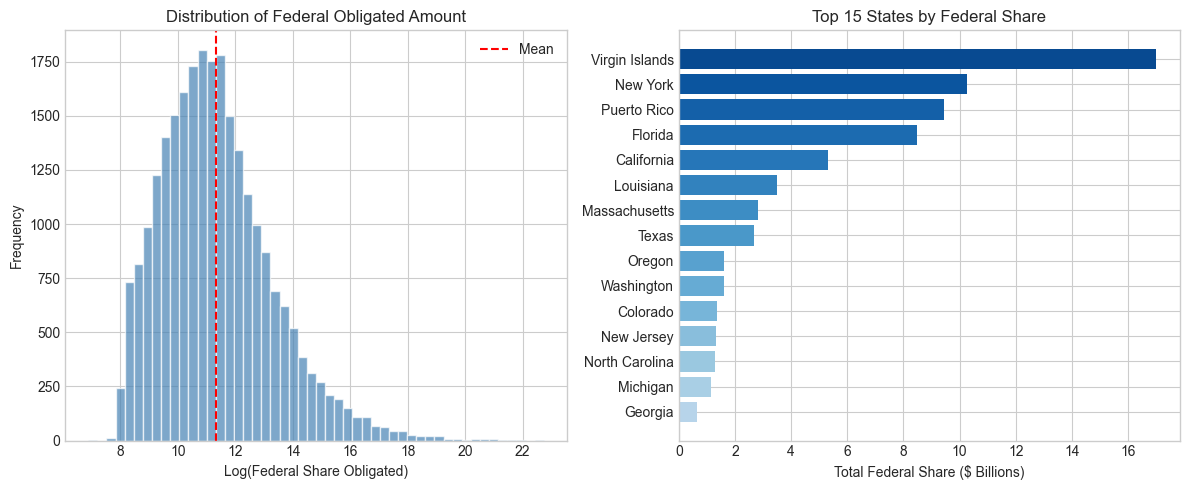

In [31]:
# EDA - Distribution Analysis

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
ax1.hist(df_eng['log_obligated'], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax1.set_xlabel('Log(Federal Share Obligated)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Federal Obligated Amount')
ax1.axvline(df_eng['log_obligated'].mean(), color='red', linestyle='--', label=f'Mean')
ax1.legend()

ax2 = axes[1]
state_totals = df_eng.groupby('stateName')['federalShareObligated'].sum().sort_values(ascending=False).head(15)
ax2.barh(range(len(state_totals)), state_totals.values / 1e9, color=plt.cm.Blues(np.linspace(0.3, 0.9, 15))[::-1])
ax2.set_yticks(range(len(state_totals)))
ax2.set_yticklabels(state_totals.index)
ax2.set_xlabel('Total Federal Share ($ Billions)')
ax2.set_title('Top 15 States by Federal Share')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('../plots/femapublic_eda_1.png', dpi=150, bbox_inches='tight')
plt.show()

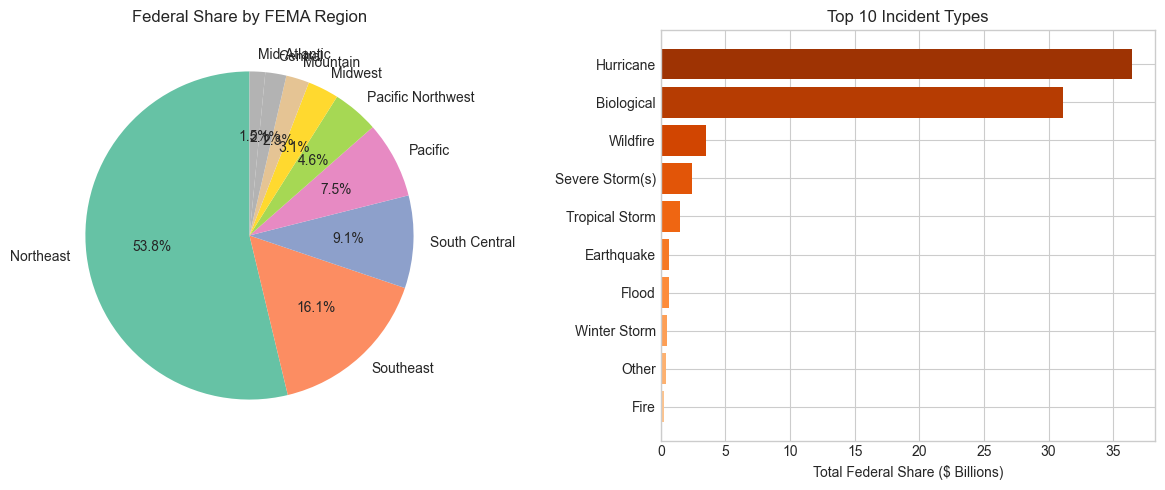

In [32]:
# EDA - Regional & Incident Analysis

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
region_totals = df_eng.groupby('region_name')['federalShareObligated'].sum().sort_values(ascending=False)
ax1.pie(region_totals.values, labels=region_totals.index, autopct='%1.1f%%', 
        colors=plt.cm.Set2(np.linspace(0, 1, len(region_totals))), startangle=90)
ax1.set_title('Federal Share by FEMA Region')

ax2 = axes[1]
incident_totals = df_eng.groupby('incidentType')['federalShareObligated'].sum().sort_values(ascending=False).head(10)
ax2.barh(range(len(incident_totals)), incident_totals.values / 1e9, 
         color=plt.cm.Oranges(np.linspace(0.3, 0.9, len(incident_totals)))[::-1])
ax2.set_yticks(range(len(incident_totals)))
ax2.set_yticklabels(incident_totals.index)
ax2.set_xlabel('Total Federal Share ($ Billions)')
ax2.set_title('Top 10 Incident Types')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('../plots/femapublic_eda_2.png', dpi=150, bbox_inches='tight')
plt.show()

In [33]:
# Prepare Features for Modeling

y = df_eng['log_obligated']

feature_cols = [
    'totalAppDamageCost', 'currentProjectCost', 'log_damage_cost', 'log_project_cost',
    'numberActiveDamages', 'numberActiveProjects', 'numberObligatedProjects',
    'log_num_damages', 'log_num_projects',
    'numberPhase2Projects', 'numberPhase3Projects', 'numberPhase4Projects', 'numberPhase5Projects',
    'pct_phase2', 'pct_phase3', 'pct_phase4', 'pct_phase5',
    'pct_cost_phase2', 'pct_cost_phase3', 'pct_cost_phase4', 'pct_cost_phase5',
    'phase2ProjectCost', 'phase3ProjectCost', 'phase4ProjectCost', 'phase5ProjectCost',
    'cost_per_project', 'damage_to_cost_ratio', 'federal_share_pct',
    'is_pnp', 'uses_direct_app', 'declaration_year', 'declaration_month',
    'state_encoded', 'incident_encoded', 'applicant_type_encoded', 'region_encoded'
]

existing_cols = [col for col in feature_cols if col in df_eng.columns]
X = df_eng[existing_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features: {len(existing_cols)}, Train: {len(X_train):,}, Test: {len(X_test):,}")

Features: 36, Train: 20,295, Test: 5,074


In [34]:
# Train Baseline Models - Federal Share Prediction

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1, verbose=-1)
}

results = {}
for name, model in models.items():
    if 'Linear' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2, 'model': model}
    print(f"{name}: R2={r2:.4f}, RMSE={rmse:.4f}")

print(f"\nBest: {max(results, key=lambda x: results[x]['R2'])}")

Linear Regression: R2=0.9736, RMSE=0.3155
Random Forest: R2=0.9963, RMSE=0.1178
Random Forest: R2=0.9963, RMSE=0.1178
Gradient Boosting: R2=0.9981, RMSE=0.0846
Gradient Boosting: R2=0.9981, RMSE=0.0846
XGBoost: R2=0.9973, RMSE=0.1003
XGBoost: R2=0.9973, RMSE=0.1003
LightGBM: R2=0.9969, RMSE=0.1078

Best: Gradient Boosting
LightGBM: R2=0.9969, RMSE=0.1078

Best: Gradient Boosting


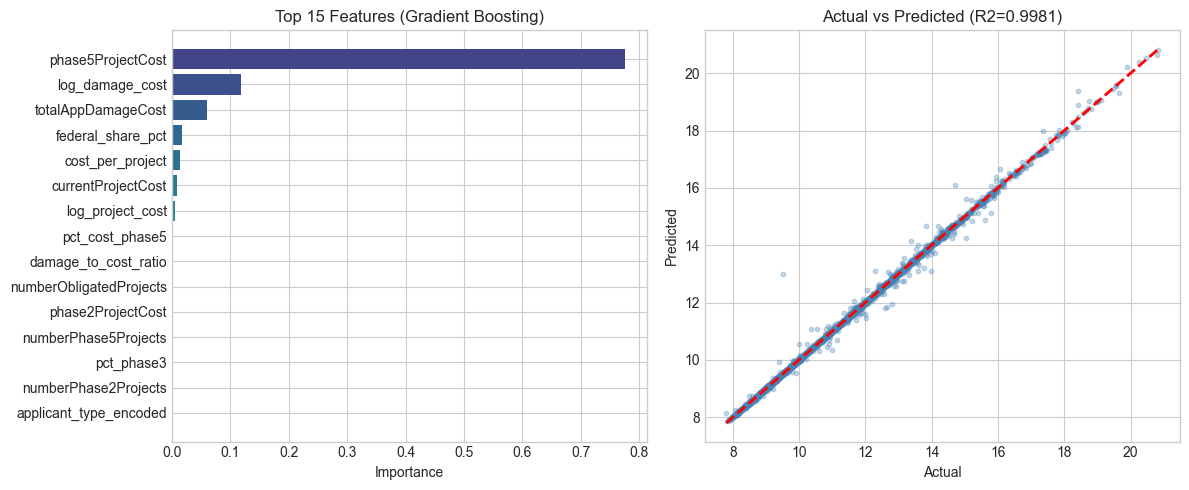

In [35]:
# Feature Importance Analysis

best_model = results['Gradient Boosting']['model']
feature_importance = pd.DataFrame({
    'feature': X.columns, 'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
top_features = feature_importance.head(15)
ax1.barh(range(len(top_features)), top_features['importance'].values, 
         color=plt.cm.viridis(np.linspace(0.2, 0.8, len(top_features))))
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['feature'].values)
ax1.set_xlabel('Importance')
ax1.set_title('Top 15 Features (Gradient Boosting)')
ax1.invert_yaxis()

ax2 = axes[1]
y_pred_best = best_model.predict(X_test)
ax2.scatter(y_test, y_pred_best, alpha=0.3, s=10, c='steelblue')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title(f'Actual vs Predicted (R2={results["Gradient Boosting"]["R2"]:.4f})')

plt.tight_layout()
plt.savefig('../plots/femapublic_model_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [36]:
# Classification Model - Funding Levels

def categorize_funding(amount):
    if amount < 50000: return 'Low (<$50K)'
    elif amount < 500000: return 'Medium ($50K-$500K)'
    elif amount < 5000000: return 'High ($500K-$5M)'
    else: return 'Very High (>$5M)'

df_eng['funding_level'] = df_eng['federalShareObligated'].apply(categorize_funding)
print(f"Funding Levels:\n{df_eng['funding_level'].value_counts()}")

le_target = LabelEncoder()
y_class = le_target.fit_transform(df_eng['funding_level'])
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_c, y_train_c)
y_pred_c = rf_clf.predict(X_test_c)

accuracy = (y_pred_c == y_test_c).mean()
f1 = f1_score(y_test_c, y_pred_c, average='weighted')
print(f"\nAccuracy: {accuracy:.4f}, F1: {f1:.4f}")

Funding Levels:
funding_level
Low (<$50K)            11007
Medium ($50K-$500K)    10200
High ($500K-$5M)        3236
Very High (>$5M)         926
Name: count, dtype: int64

Accuracy: 0.9941, F1: 0.9941

Accuracy: 0.9941, F1: 0.9941


In [37]:
# Hyperparameter Tuning - Random Forest

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1), 
    param_distributions=param_dist,
    n_iter=20, cv=3, scoring='r2', random_state=42, n_jobs=-1, verbose=1
)
random_search.fit(X_train, y_train)

y_pred_tuned = random_search.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
print(f"\nTuned RF R2: {r2_tuned:.4f} (Baseline: {results['Random Forest']['R2']:.4f})")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Tuned RF R2: 0.9963 (Baseline: 0.9963)

Tuned RF R2: 0.9963 (Baseline: 0.9963)


In [38]:
# Stacking Ensemble Model

base_estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1, verbosity=0)),
    ('lgbm', LGBMRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1, verbose=-1))
]

stacking_reg = StackingRegressor(estimators=base_estimators, final_estimator=Ridge(alpha=1.0), cv=3, n_jobs=-1)
stacking_reg.fit(X_train, y_train)

y_pred_stack = stacking_reg.predict(X_test)
r2_stack = r2_score(y_test, y_pred_stack)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))

print(f"Stacking R2: {r2_stack:.4f}, RMSE: {rmse_stack:.4f}")
print(f"Improvement over GB: {((r2_stack - results['Gradient Boosting']['R2']) / results['Gradient Boosting']['R2']) * 100:+.2f}%")

Stacking R2: 0.9983, RMSE: 0.0806
Improvement over GB: +0.02%


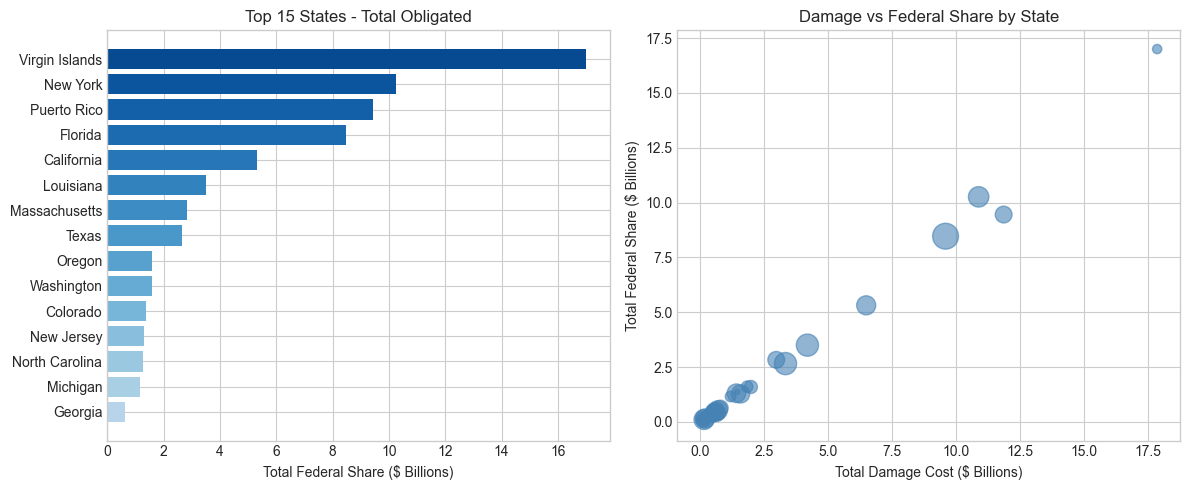

In [39]:
# Geographic Analysis

state_summary = df_eng.groupby('stateName').agg({
    'federalShareObligated': ['sum', 'mean', 'count'],
    'totalAppDamageCost': 'sum'
}).round(2)
state_summary.columns = ['Total_Obligated', 'Avg_Obligated', 'Records', 'Total_Damage']
state_summary = state_summary.sort_values('Total_Obligated', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
top_states = state_summary.head(15)
ax1.barh(range(len(top_states)), top_states['Total_Obligated'] / 1e9, 
         color=plt.cm.Blues(np.linspace(0.3, 0.9, len(top_states)))[::-1])
ax1.set_yticks(range(len(top_states)))
ax1.set_yticklabels(top_states.index)
ax1.set_xlabel('Total Federal Share ($ Billions)')
ax1.set_title('Top 15 States - Total Obligated')
ax1.invert_yaxis()

ax2 = axes[1]
ax2.scatter(state_summary['Total_Damage']/1e9, state_summary['Total_Obligated']/1e9, 
            s=state_summary['Records']/5, alpha=0.6, c='steelblue')
ax2.set_xlabel('Total Damage Cost ($ Billions)')
ax2.set_ylabel('Total Federal Share ($ Billions)')
ax2.set_title('Damage vs Federal Share by State')

plt.tight_layout()
plt.savefig('../plots/femapublic_geographic.png', dpi=150, bbox_inches='tight')
plt.show()

In [40]:
# Damage Cost Prediction - Setup

damage_feature_cols = [
    'numberActiveDamages', 'numberActiveProjects', 'numberObligatedProjects',
    'log_num_damages', 'log_num_projects',
    'numberPhase2Projects', 'numberPhase3Projects', 'numberPhase4Projects', 'numberPhase5Projects',
    'pct_phase2', 'pct_phase3', 'pct_phase4', 'pct_phase5',
    'is_pnp', 'uses_direct_app', 'declaration_year', 'declaration_month',
    'state_encoded', 'incident_encoded', 'applicant_type_encoded', 'region_encoded'
]

df_damage = df_eng[df_eng['totalAppDamageCost'] > 0].copy()
y_damage = np.log1p(df_damage['totalAppDamageCost'])

existing_damage_cols = [col for col in damage_feature_cols if col in df_damage.columns]
X_damage = df_damage[existing_damage_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_damage, y_damage, test_size=0.2, random_state=42)
print(f"Damage prediction: {len(existing_damage_cols)} features, {len(X_train_d):,} train, {len(X_test_d):,} test")

Damage prediction: 21 features, 20,294 train, 5,074 test


In [41]:
# Train Damage Prediction Models

damage_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1, verbose=-1)
}

scaler_d = StandardScaler()
X_train_d_scaled = scaler_d.fit_transform(X_train_d)
X_test_d_scaled = scaler_d.transform(X_test_d)

damage_results = {}
for name, model in damage_models.items():
    if 'Linear' in name:
        model.fit(X_train_d_scaled, y_train_d)
        y_pred_d = model.predict(X_test_d_scaled)
    else:
        model.fit(X_train_d, y_train_d)
        y_pred_d = model.predict(X_test_d)
    
    rmse = np.sqrt(mean_squared_error(y_test_d, y_pred_d))
    r2 = r2_score(y_test_d, y_pred_d)
    damage_results[name] = {'RMSE': rmse, 'R2': r2, 'model': model}
    print(f"{name}: R2={r2:.4f}, RMSE={rmse:.4f}")

print(f"\nBest: {max(damage_results, key=lambda x: damage_results[x]['R2'])}")

Linear Regression: R2=0.4687, RMSE=1.4203
Random Forest: R2=0.5162, RMSE=1.3553
Random Forest: R2=0.5162, RMSE=1.3553
Gradient Boosting: R2=0.5413, RMSE=1.3197
XGBoost: R2=0.5493, RMSE=1.3081
Gradient Boosting: R2=0.5413, RMSE=1.3197
XGBoost: R2=0.5493, RMSE=1.3081
LightGBM: R2=0.5442, RMSE=1.3155

Best: XGBoost
LightGBM: R2=0.5442, RMSE=1.3155

Best: XGBoost


In [42]:
# Damage Severity Classification

def categorize_damage(damage):
    if damage < 100000: return 'Minor (<$100K)'
    elif damage < 1000000: return 'Moderate ($100K-$1M)'
    elif damage < 10000000: return 'Major ($1M-$10M)'
    else: return 'Severe (>$10M)'

df_damage['damage_severity'] = df_damage['totalAppDamageCost'].apply(categorize_damage)
print(f"Severity Distribution:\n{df_damage['damage_severity'].value_counts()}")

le_severity = LabelEncoder()
y_severity = le_severity.fit_transform(df_damage['damage_severity'])
X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(X_damage, y_severity, test_size=0.2, random_state=42)

rf_severity = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_severity.fit(X_train_sev, y_train_sev)
y_pred_sev = rf_severity.predict(X_test_sev)

accuracy_sev = (y_pred_sev == y_test_sev).mean()
f1_sev = f1_score(y_test_sev, y_pred_sev, average='weighted')
print(f"\nAccuracy: {accuracy_sev:.4f}, F1: {f1_sev:.4f}")

Severity Distribution:
damage_severity
Minor (<$100K)          13738
Moderate ($100K-$1M)     8469
Major ($1M-$10M)         2522
Severe (>$10M)            639
Name: count, dtype: int64

Accuracy: 0.6845, F1: 0.6670

Accuracy: 0.6845, F1: 0.6670


In [43]:
# Stacking Ensemble - Damage Prediction

damage_estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1, verbosity=0)),
    ('lgbm', LGBMRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1, verbose=-1))
]

stacking_damage = StackingRegressor(estimators=damage_estimators, final_estimator=Ridge(alpha=1.0), cv=3, n_jobs=-1)
stacking_damage.fit(X_train_d, y_train_d)

y_pred_stack_d = stacking_damage.predict(X_test_d)
r2_stack_d = r2_score(y_test_d, y_pred_stack_d)
rmse_stack_d = np.sqrt(mean_squared_error(y_test_d, y_pred_stack_d))

print(f"Stacking R2: {r2_stack_d:.4f}, RMSE: {rmse_stack_d:.4f}")

Stacking R2: 0.5520, RMSE: 1.3042


In [44]:
# Enhanced Damage Prediction with Additional Features

enhanced_damage_cols = damage_feature_cols + [
    'phase2ProjectCost', 'phase3ProjectCost', 'phase4ProjectCost', 'phase5ProjectCost',
    'pct_cost_phase2', 'pct_cost_phase3', 'pct_cost_phase4', 'pct_cost_phase5',
    'federalShareObligated', 'log_obligated', 'cost_per_project'
]

existing_enhanced_cols = [col for col in enhanced_damage_cols if col in df_damage.columns]
X_damage_enhanced = df_damage[existing_enhanced_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

X_train_d2, X_test_d2, y_train_d2, y_test_d2 = train_test_split(
    X_damage_enhanced, y_damage, test_size=0.2, random_state=42)

print(f"Enhanced features: {len(existing_enhanced_cols)} (was {len(existing_damage_cols)})")

Enhanced features: 32 (was 21)


In [45]:
# Train Enhanced Models

import lightgbm as lgb

scaler = StandardScaler()
X_train_d2_scaled = scaler.fit_transform(X_train_d2)
X_test_d2_scaled = scaler.transform(X_test_d2)

improved_models = {
    'XGBoost': XGBRegressor(n_estimators=500, max_depth=8, learning_rate=0.05, subsample=0.8, 
                            colsample_bytree=0.8, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=500, max_depth=8, learning_rate=0.05, subsample=0.8,
                                   colsample_bytree=0.8, random_state=42, n_jobs=-1, verbose=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=300, max_depth=6, learning_rate=0.05,
                                                   subsample=0.8, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=300, max_depth=15, min_samples_split=5,
                                          random_state=42, n_jobs=-1)
}

improved_results = {}
for name, model in improved_models.items():
    model.fit(X_train_d2, y_train_d2)
    y_pred = model.predict(X_test_d2)
    r2 = r2_score(y_test_d2, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_d2, y_pred))
    improved_results[name] = {'R2': r2, 'RMSE': rmse, 'model': model}
    print(f"{name}: R2={r2:.4f}")

best_improved = max(improved_results.items(), key=lambda x: x[1]['R2'])
print(f"\nBest: {best_improved[0]} (R2={best_improved[1]['R2']:.4f})")

XGBoost: R2=0.9848
LightGBM: R2=0.9854
LightGBM: R2=0.9854
GradientBoosting: R2=0.9862
GradientBoosting: R2=0.9862
RandomForest: R2=0.9838

Best: GradientBoosting (R2=0.9862)
RandomForest: R2=0.9838

Best: GradientBoosting (R2=0.9862)


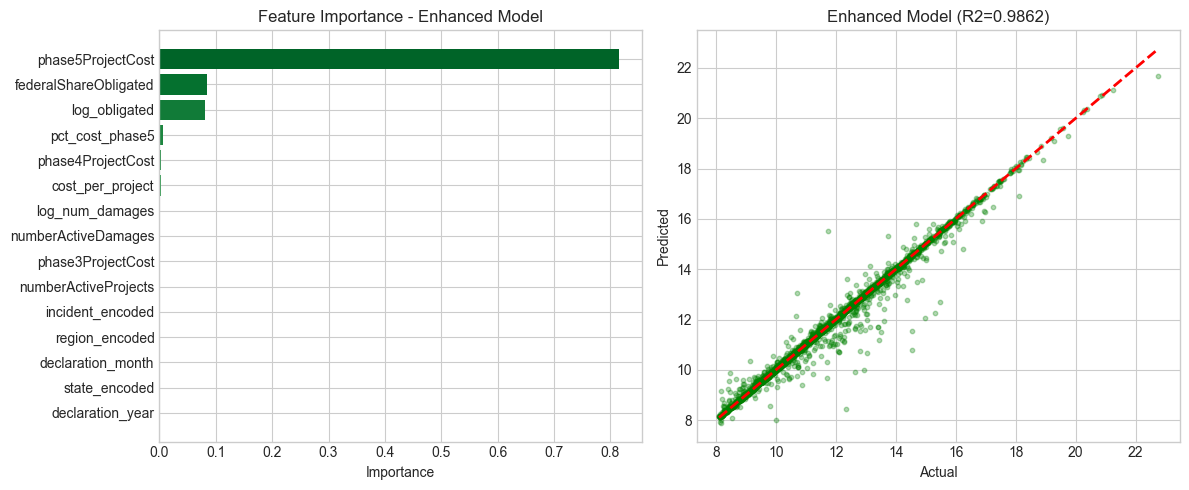

In [46]:
# Enhanced Model Analysis

best_improved_name = 'GradientBoosting'
best_improved_model = improved_results[best_improved_name]['model']

improved_importance = pd.DataFrame({
    'feature': existing_enhanced_cols,
    'importance': best_improved_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
top_imp_features = improved_importance.head(15)
ax1.barh(range(len(top_imp_features)), top_imp_features['importance'].values, 
         color=plt.cm.Greens(np.linspace(0.3, 0.9, len(top_imp_features)))[::-1])
ax1.set_yticks(range(len(top_imp_features)))
ax1.set_yticklabels(top_imp_features['feature'].values)
ax1.set_xlabel('Importance')
ax1.set_title('Feature Importance - Enhanced Model')
ax1.invert_yaxis()

ax2 = axes[1]
y_pred_improved = best_improved_model.predict(X_test_d2)
ax2.scatter(y_test_d2, y_pred_improved, alpha=0.3, s=10, c='green')
ax2.plot([y_test_d2.min(), y_test_d2.max()], [y_test_d2.min(), y_test_d2.max()], 'r--', lw=2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title(f'Enhanced Model (R2={improved_results[best_improved_name]["R2"]:.4f})')

plt.tight_layout()
plt.savefig('../plots/femapublic_improved_damage.png', dpi=150, bbox_inches='tight')
plt.show()

In [47]:
# Add Damage Category Features from Projects Details

proj_details = datasets['projects_details'].copy()
print(f"Damage Categories:\n{proj_details['damageCategoryCode'].value_counts()}")

damage_cat_agg = proj_details.groupby('disasterNumber').agg({
    'damageCategoryCode': lambda x: x.value_counts().to_dict(),
    'projectSize': lambda x: (x == 'Large').sum(),
    'projectAmount': ['sum', 'mean', 'count']
}).reset_index()
damage_cat_agg.columns = ['disasterNumber', 'damage_cat_dist', 'large_project_count', 
                          'total_project_amount', 'avg_project_amount', 'project_count']

for cat in 'ABCDEFG':
    damage_cat_agg[f'cat_{cat}_count'] = damage_cat_agg['damage_cat_dist'].apply(
        lambda x: x.get(cat, 0) if isinstance(x, dict) else 0)

total_cats = damage_cat_agg[[f'cat_{c}_count' for c in 'ABCDEFG']].sum(axis=1).replace(0, 1)
for cat in 'ABCDEFG':
    damage_cat_agg[f'cat_{cat}_pct'] = damage_cat_agg[f'cat_{cat}_count'] / total_cats

damage_cat_agg = damage_cat_agg.drop('damage_cat_dist', axis=1)
print(f"Created {len(damage_cat_agg.columns)-1} features")

Damage Categories:
damageCategoryCode
C    12622
B    12534
E     9612
A     6703
G     3699
F     2655
Z     1151
D     1024
Name: count, dtype: int64
Created 18 features


In [48]:
# Train Model with Severity Features (No Cost Leakage)

df_damage_enriched = df_damage.merge(damage_cat_agg, on='disasterNumber', how='left')
for col in damage_cat_agg.columns:
    if col != 'disasterNumber':
        df_damage_enriched[col] = df_damage_enriched[col].fillna(0)

no_leak_features = damage_feature_cols + [
    'large_project_count', 'project_count',
    'cat_A_count', 'cat_B_count', 'cat_C_count', 'cat_D_count', 'cat_E_count', 'cat_F_count', 'cat_G_count',
    'cat_A_pct', 'cat_B_pct', 'cat_C_pct', 'cat_D_pct', 'cat_E_pct', 'cat_F_pct', 'cat_G_pct',
]

existing_noleak = [col for col in no_leak_features if col in df_damage_enriched.columns]
X_noleak = df_damage_enriched[existing_noleak].replace([np.inf, -np.inf], np.nan).fillna(0)
y_noleak = np.log1p(df_damage_enriched['totalAppDamageCost'])

X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(X_noleak, y_noleak, test_size=0.2, random_state=42)

noleak_models = {
    'XGBoost': XGBRegressor(n_estimators=300, max_depth=8, learning_rate=0.05, random_state=42, n_jobs=-1, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=300, max_depth=8, learning_rate=0.05, random_state=42, n_jobs=-1, verbose=-1),
}

noleak_results = {}
for name, model in noleak_models.items():
    model.fit(X_train_nl, y_train_nl)
    y_pred_nl = model.predict(X_test_nl)
    r2 = r2_score(y_test_nl, y_pred_nl)
    noleak_results[name] = {'R2': r2, 'model': model}
    print(f"{name}: R2={r2:.4f}")

best_noleak = max(noleak_results.items(), key=lambda x: x[1]['R2'])
print(f"\nNo-leak model R2: {best_noleak[1]['R2']:.4f} ({len(existing_noleak)} features)")

XGBoost: R2=0.5388
LightGBM: R2=0.5513

No-leak model R2: 0.5513 (37 features)
LightGBM: R2=0.5513

No-leak model R2: 0.5513 (37 features)


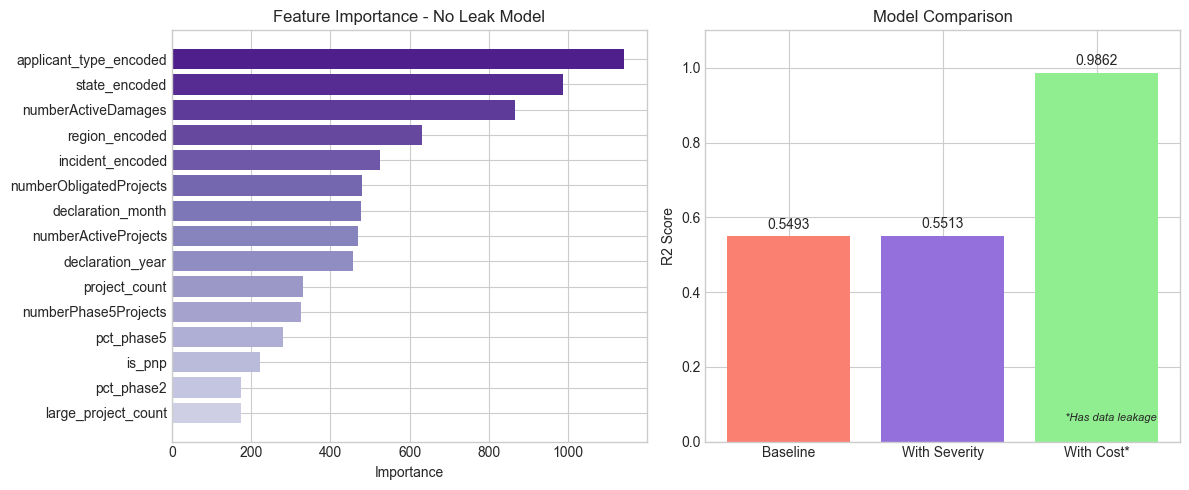

In [49]:
# No-Leak Model Feature Importance

best_nl_model = noleak_results['LightGBM']['model']
noleak_importance = pd.DataFrame({
    'feature': existing_noleak,
    'importance': best_nl_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
top_nl_feat = noleak_importance.head(15)
ax1.barh(range(len(top_nl_feat)), top_nl_feat['importance'].values, 
         color=plt.cm.Purples(np.linspace(0.3, 0.9, len(top_nl_feat)))[::-1])
ax1.set_yticks(range(len(top_nl_feat)))
ax1.set_yticklabels(top_nl_feat['feature'].values)
ax1.set_xlabel('Importance')
ax1.set_title('Feature Importance - No Leak Model')
ax1.invert_yaxis()

ax2 = axes[1]
model_comp = {'Model': ['Baseline', 'With Severity', 'With Cost*'], 'R2': [0.5493, best_noleak[1]['R2'], 0.9862]}
bars = ax2.bar(model_comp['Model'], model_comp['R2'], color=['salmon', 'mediumpurple', 'lightgreen'])
ax2.set_ylabel('R2 Score')
ax2.set_title('Model Comparison')
ax2.set_ylim(0, 1.1)
for bar, r2 in zip(bars, model_comp['R2']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{r2:.4f}', ha='center')
ax2.text(0.95, 0.05, '*Has data leakage', transform=ax2.transAxes, fontsize=8, ha='right', style='italic')

plt.tight_layout()
plt.savefig('../plots/femapublic_noleak_model.png', dpi=150, bbox_inches='tight')
plt.show()

In [50]:
# Merge All Datasets - Create Comprehensive Features

applicants = datasets['applicants'].copy()
if 'zipCode' in applicants.columns:
    applicants['zip_prefix'] = applicants['zipCode'].astype(str).str[:3]
    applicants['zip_prefix_num'] = pd.to_numeric(applicants['zip_prefix'], errors='coerce').fillna(0)
    app_agg = applicants.groupby('disasterNumber').agg({
        'zip_prefix_num': ['mean', 'std', 'nunique'], 'applicantId': 'nunique'
    }).reset_index()
    app_agg.columns = ['disasterNumber', 'avg_zip', 'zip_std', 'zip_diversity', 'num_applicants']

proj_summary = datasets['projects_summary'].copy()
ps_agg = proj_summary.groupby('disasterNumber').agg({
    'numberOfProjects': ['sum', 'mean', 'max'],
    'educationApplicant': lambda x: x.astype(str).str.lower().str.contains('true|yes|1').sum()
}).reset_index()
ps_agg.columns = ['disasterNumber', 'ps_total_projects', 'ps_avg_projects', 'ps_max_projects', 'education_applicants']

grants = datasets['grants'].copy()
grants_agg = grants.groupby('disasterNumber').agg({'federalShareObligated': 'count'}).reset_index()
grants_agg.columns = ['disasterNumber', 'grants_count']

appeals = datasets['appeals'].copy()
appeals_agg = appeals.groupby('disasterNumber').agg({'status': 'count'}).reset_index()
appeals_agg.columns = ['disasterNumber', 'appeal_count']

print(f"Created aggregates from: Applicants, Projects Summary, Grants, Appeals")

Created aggregates from: Applicants, Projects Summary, Grants, Appeals


In [51]:
# Build Comprehensive Dataset

df_comprehensive = df_damage_enriched.copy()
df_comprehensive['disasterNumber'] = df_comprehensive['disasterNumber'].astype(str)

for agg_df in [app_agg, ps_agg, grants_agg, appeals_agg]:
    agg_df['disasterNumber'] = agg_df['disasterNumber'].astype(str)
    df_comprehensive = df_comprehensive.merge(agg_df, on='disasterNumber', how='left')

for col in df_comprehensive.select_dtypes(include=[np.number]).columns:
    df_comprehensive[col] = df_comprehensive[col].fillna(0)

comprehensive_features = no_leak_features + [
    'avg_zip', 'zip_std', 'zip_diversity', 'num_applicants',
    'ps_total_projects', 'ps_avg_projects', 'ps_max_projects', 'education_applicants',
    'grants_count', 'appeal_count'
]

existing_comp = [col for col in comprehensive_features if col in df_comprehensive.columns]
print(f"Comprehensive features: {len(existing_comp)}")

Comprehensive features: 47


In [52]:
# Train Comprehensive Model

X_comp = df_comprehensive[existing_comp].replace([np.inf, -np.inf], np.nan).fillna(0)
y_comp = np.log1p(df_comprehensive['totalAppDamageCost'])

X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(X_comp, y_comp, test_size=0.2, random_state=42)

comp_models = {
    'XGBoost': XGBRegressor(n_estimators=300, max_depth=8, learning_rate=0.05, subsample=0.8, random_state=42, n_jobs=-1, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=300, max_depth=8, learning_rate=0.05, subsample=0.8, random_state=42, n_jobs=-1, verbose=-1),
    'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
}

comp_results = {}
for name, model in comp_models.items():
    model.fit(X_train_comp, y_train_comp)
    y_pred_comp = model.predict(X_test_comp)
    r2 = r2_score(y_test_comp, y_pred_comp)
    comp_results[name] = {'R2': r2, 'model': model}
    print(f"{name}: R2={r2:.4f}")

best_comp = max(comp_results.items(), key=lambda x: x[1]['R2'])
print(f"\nBest comprehensive model: {best_comp[0]} (R2={best_comp[1]['R2']:.4f})")

XGBoost: R2=0.5365
LightGBM: R2=0.5516
LightGBM: R2=0.5516
RandomForest: R2=0.5119

Best comprehensive model: LightGBM (R2=0.5516)
RandomForest: R2=0.5119

Best comprehensive model: LightGBM (R2=0.5516)


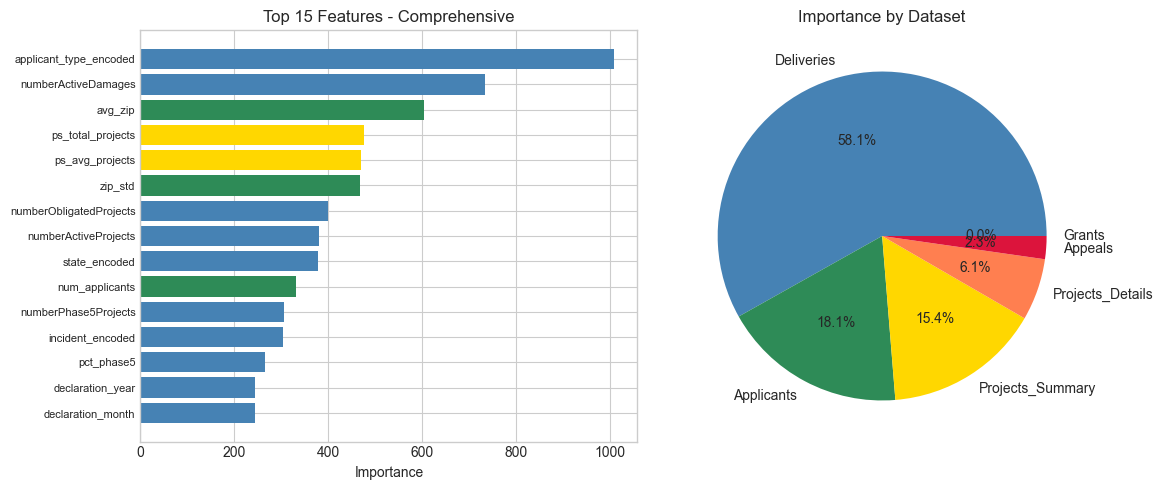

In [53]:
# Comprehensive Model - Feature Importance by Source

best_comp_model = comp_results['LightGBM']['model']
comp_importance = pd.DataFrame({
    'feature': existing_comp,
    'importance': best_comp_model.feature_importances_
}).sort_values('importance', ascending=False)

def get_source(feat):
    if feat in ['avg_zip', 'zip_std', 'zip_diversity', 'num_applicants']: return 'Applicants'
    elif 'cat_' in feat or feat in ['large_project_count', 'project_count']: return 'Projects_Details'
    elif feat.startswith('ps_') or feat == 'education_applicants': return 'Projects_Summary'
    elif feat in ['grants_count']: return 'Grants'
    elif feat == 'appeal_count': return 'Appeals'
    else: return 'Deliveries'

comp_importance['source'] = comp_importance['feature'].apply(get_source)
source_importance = comp_importance.groupby('source')['importance'].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors_by_source = {'Deliveries': 'steelblue', 'Projects_Details': 'coral', 'Applicants': 'seagreen',
                    'Projects_Summary': 'gold', 'Grants': 'mediumpurple', 'Appeals': 'crimson'}

ax1 = axes[0]
top_comp_feat = comp_importance.head(15)
bar_colors = [colors_by_source[s] for s in top_comp_feat['source']]
ax1.barh(range(len(top_comp_feat)), top_comp_feat['importance'].values, color=bar_colors)
ax1.set_yticks(range(len(top_comp_feat)))
ax1.set_yticklabels(top_comp_feat['feature'].values, fontsize=8)
ax1.set_xlabel('Importance')
ax1.set_title('Top 15 Features - Comprehensive')
ax1.invert_yaxis()

ax2 = axes[1]
source_colors = [colors_by_source[s] for s in source_importance.index]
ax2.pie(source_importance.values, labels=source_importance.index, autopct='%1.1f%%', colors=source_colors)
ax2.set_title('Importance by Dataset')

plt.tight_layout()
plt.savefig('../plots/femapublic_comprehensive.png', dpi=150, bbox_inches='tight')
plt.show()

In [54]:
# Summary - All Models

print("FEDERAL SHARE PREDICTION")
print(f"{'Model':<25} {'R2':<10} {'RMSE':<10}")
print("-" * 45)
for name in ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
    print(f"{name:<25} {results[name]['R2']:<10.4f} {results[name]['RMSE']:<10.4f}")
print(f"{'Stacking Ensemble':<25} {r2_stack:<10.4f} {rmse_stack:<10.4f}")
print(f"\nBest: Stacking (R2={r2_stack:.4f})")

print("\nDAMAGE COST PREDICTION")
print(f"{'Model':<25} {'R2':<10}")
print("-" * 35)
for name in damage_results:
    print(f"{name:<25} {damage_results[name]['R2']:<10.4f}")
print(f"{'Stacking Ensemble':<25} {r2_stack_d:<10.4f}")

print("\nCLASSIFICATION")
print(f"Funding Level Accuracy: {accuracy:.4f}")
print(f"Damage Severity Accuracy: {accuracy_sev:.4f}")

FEDERAL SHARE PREDICTION
Model                     R2         RMSE      
---------------------------------------------
Linear Regression         0.9736     0.3155    
Random Forest             0.9963     0.1178    
Gradient Boosting         0.9981     0.0846    
XGBoost                   0.9973     0.1003    
LightGBM                  0.9969     0.1078    
Stacking Ensemble         0.9983     0.0806    

Best: Stacking (R2=0.9983)

DAMAGE COST PREDICTION
Model                     R2        
-----------------------------------
Linear Regression         0.4687    
Random Forest             0.5162    
Gradient Boosting         0.5413    
XGBoost                   0.5493    
LightGBM                  0.5442    
Stacking Ensemble         0.5520    

CLASSIFICATION
Funding Level Accuracy: 0.9941
Damage Severity Accuracy: 0.6845


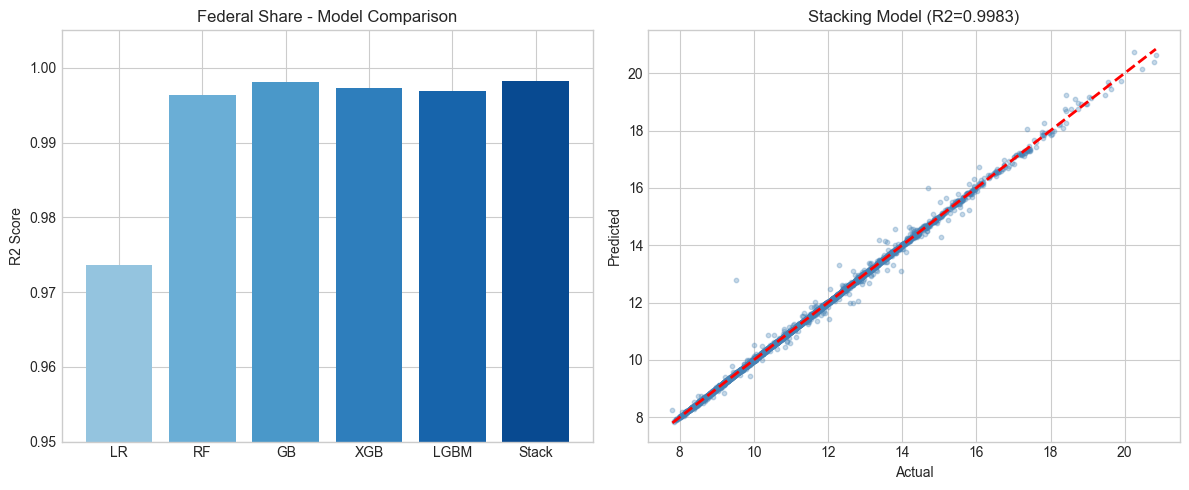

In [55]:
# Final Visualization - Federal Share Prediction

rf_estimator = stacking_reg.named_estimators_['rf']
feature_importance = pd.DataFrame({
    'feature': X.columns, 'importance': rf_estimator.feature_importances_
}).sort_values('importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
models_list = ['LR', 'RF', 'GB', 'XGB', 'LGBM', 'Stack']
funding_r2_all = [results['Linear Regression']['R2'], results['Random Forest']['R2'],
                  results['Gradient Boosting']['R2'], results['XGBoost']['R2'],
                  results['LightGBM']['R2'], r2_stack]
ax1.bar(models_list, funding_r2_all, color=plt.cm.Blues(np.linspace(0.4, 0.9, len(models_list))))
ax1.set_ylabel('R2 Score')
ax1.set_title('Federal Share - Model Comparison')
ax1.set_ylim(0.95, 1.005)

ax2 = axes[1]
y_pred_funding = stacking_reg.predict(X_test)
ax2.scatter(y_test, y_pred_funding, alpha=0.3, s=10, c='steelblue')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title(f'Stacking Model (R2={r2_stack:.4f})')

plt.tight_layout()
plt.savefig('../plots/femapublic_funding_final.png', dpi=150, bbox_inches='tight')
plt.show()

# FEMA Public Assistance Dataset Analysis

## Source Data
**Source:** FEMA Open Data API - Public Assistance Programs  
**Original Size:** 50,000 records per dataset  
**Files:** PublicAssistanceApplicants (V1), PublicAssistanceApplicantsProgramDeliveries (V1), PublicAssistanceFundedProjectsDetails (V2), PublicAssistanceFundedProjectsSummaries (V1), PublicAssistanceGrantAwardActivities (V2), PublicAssistanceSecondAppealsTracker (V1)  
**Analysis Sample:** 25,369 records with federal share obligated > 0  
**Target Variable:** Federal Share Obligated (government assistance disbursed)  
**Time Period:** Historical disaster assistance data  
**Domain:** Disaster relief funding and damage cost prediction

---

## Datasets

| Dataset | Description | Records |
|---------|-------------|---------|
| Applicants | Applicant organisation information | 50,000 |
| Deliveries | Program delivery and funding details | 50,000 |
| Projects Details | Individual project-level data | 50,000 |
| Projects Summary | Aggregated project summaries | 50,000 |
| Grants | Grant award activities | 50,000 |
| Appeals | Second appeals tracker | 1,559 |

---

## Target Variables

| Task | Target Variable | Description | Use Case |
|------|-----------------|-------------|----------|
| Regression | log_obligated | Log-transformed federal share obligated | Funding estimation |
| Regression | log_damage | Log-transformed total damage cost | Damage prediction |
| Classification | FUNDING_LEVEL | 4-level funding categories | Budget planning |
| Classification | DAMAGE_SEVERITY | 4-level damage severity | Risk categorisation |

---

## Model Purpose and Prediction Goals

### Regression Models: Predicting Federal Share Obligated
**Purpose:** Estimate the dollar amount of federal assistance for disaster-affected applicants.

**What They Predict:** Given characteristics of a disaster (damage costs, project phases, applicant type, geographic region), regression models predict the continuous dollar value of federal share obligated. The target is log-transformed to handle the highly skewed distribution.

**Use Cases:**
- Budget forecasting for disaster response
- Resource allocation planning
- Policy analysis and funding efficiency
- Recovery timeline estimation

**Example Prediction:** "An applicant in Florida with $5M total damage and 10 active projects is predicted to receive approximately $3.2M in federal assistance."

### Classification Models: Categorising Funding Levels
**Purpose:** Categorise disaster applicants into funding severity levels.

**What They Predict:** One of 4 funding levels: Low (<$50K), Medium ($50K-$500K), High ($500K-$5M), Very High (>$5M).

**Use Cases:**
- Triage systems for application processing
- Early warning for large-scale disasters
- Capacity planning for FEMA regional offices
- Reporting and congressional briefings

---

## Funding Level Distribution (Classification)

| Category | Range | Count | Distribution |
|----------|-------|-------|--------------|
| Low | <$50K | 11,007 | 43.4% |
| Medium | $50K-$500K | 10,200 | 40.2% |
| High | $500K-$5M | 3,236 | 12.8% |
| Very High | >$5M | 926 | 3.6% |

## Damage Severity Distribution

| Category | Range | Count | Distribution |
|----------|-------|-------|--------------|
| Minor | <$100K | 13,738 | 54.2% |
| Moderate | $100K-$1M | 8,469 | 33.4% |
| Major | $1M-$10M | 2,522 | 9.9% |
| Severe | >$10M | 639 | 2.5% |

---

## Feature Engineering

### Cost and Damage Features
- **totalAppDamageCost**: Total assessed damage for applicant (raw from deliveries)
- **currentProjectCost**: Current estimated project cost (raw from deliveries)
- **log_damage_cost**: Log-transformed damage using log1p(totalAppDamageCost)
- **log_project_cost**: Log-transformed project cost using log1p(currentProjectCost)
- **log_obligated**: Log-transformed federal share using log1p(federalShareObligated)
- **federal_share_pct**: Federal share as percentage of project cost (federalShareObligated / currentProjectCost)
- **damage_to_cost_ratio**: Damage relative to project cost (totalAppDamageCost / currentProjectCost)
- **cost_per_project**: Average cost per obligated project (federalShareObligated / numberObligatedProjects)

### Project Phase Features
- **numberPhase2Projects**: Count of Phase 2 projects (raw from deliveries)
- **numberPhase3Projects**: Count of Phase 3 projects (raw from deliveries)
- **numberPhase4Projects**: Count of Phase 4 projects (raw from deliveries)
- **numberPhase5Projects**: Count of Phase 5 projects (raw from deliveries)
- **phase2ProjectCost**: Total cost of Phase 2 projects (raw from deliveries)
- **phase3ProjectCost**: Total cost of Phase 3 projects (raw from deliveries)
- **phase4ProjectCost**: Total cost of Phase 4 projects (raw from deliveries)
- **phase5ProjectCost**: Total cost of Phase 5 projects (raw from deliveries)
- **pct_phase2 to pct_phase5**: Percentage of projects in each phase (numberPhaseXProjects / total_projects)
- **pct_cost_phase2 to pct_cost_phase5**: Percentage of cost in each phase (phaseXProjectCost / total_cost)

### Project Activity Features
- **numberActiveDamages**: Count of active damage assessments (raw from deliveries)
- **numberActiveProjects**: Count of active projects (raw from deliveries)
- **numberObligatedProjects**: Count of projects with funding (raw from deliveries)
- **log_num_damages**: Log-transformed damage count using log1p(numberActiveDamages)
- **log_num_projects**: Log-transformed project count using log1p(numberActiveProjects)

### Geographic Features
- **state_encoded**: Numeric encoding of state using LabelEncoder(stateName)
- **region_name**: FEMA region name mapped from region code
- **region_encoded**: Numeric encoding of region using LabelEncoder(region_name)

### Applicant Features
- **applicant_type_encoded**: Numeric encoding of applicant type using LabelEncoder(applicantType)
- **incident_encoded**: Numeric encoding of incident type using LabelEncoder(incidentType)
- **is_pnp**: Binary flag for Private Non-Profit organisation (isPnp converted to int)
- **uses_direct_app**: Binary flag for Direct Application method (utilizingDirectApplication to int)

### Temporal Features
- **declaration_year**: Year of disaster declaration extracted from declarationDate
- **declaration_month**: Month of disaster declaration extracted from declarationDate

### Damage Category Features (from Projects Details)
- **cat_A_count to cat_G_count**: Count of projects in each damage category (A-G) aggregated by disasterNumber
- **cat_A_pct to cat_G_pct**: Percentage of each category (cat_X_count / total_categories)
- **large_project_count**: Count of large-scale projects where projectSize == 'Large'
- **project_count**: Total project count per disaster

### Applicants Dataset Features
- **avg_zip**: Average zip code prefix by disaster (mean of first 3 digits)
- **zip_std**: Zip code standard deviation by disaster
- **zip_diversity**: Count of unique zip code prefixes by disaster
- **num_applicants**: Number of unique applicants by disaster

### Projects Summary Features
- **ps_total_projects**: Total projects from summary aggregated by disaster
- **ps_avg_projects**: Average projects per applicant by disaster
- **ps_max_projects**: Maximum projects for any applicant by disaster
- **education_applicants**: Count of education applicants by disaster

### Grants and Appeals Features
- **grants_count**: Number of grant activities by disasterNumber
- **appeal_count**: Number of second appeals by disasterNumber (complexity indicator)

---

## Machine Learning Techniques

### Regression Models
- Linear Regression
- Random Forest
- Gradient Boosting
- XGBoost
- LightGBM
- Stacking Ensemble

### Classification Models
- Random Forest Classifier

### Training Strategy
- Train/test split: 80-20
- Randomised hyperparameter search (20 iterations)
- Cross-validation: 3-fold
- Random seed: 42
- Features: 36+ engineered features

---

## Model Results

### Federal Share Prediction (log_obligated)

| Model | R² Score | RMSE | Rank |
|-------|----------|------|------|
| Stacking Ensemble | 0.9983 | 0.0806 | 1 |
| Gradient Boosting | 0.9981 | 0.0846 | 2 |
| XGBoost | 0.9973 | 0.1003 | 3 |
| LightGBM | 0.9969 | 0.1078 | 4 |
| Random Forest | 0.9963 | 0.1178 | 5 |
| Linear Regression | 0.9736 | 0.3155 | 6 |

### Damage Cost Prediction (log_damage) - No Leakage Model

| Model | R² Score | RMSE | Rank |
|-------|----------|------|------|
| LightGBM (Comprehensive) | 0.5516 | 1.3042 | 1 |
| XGBoost | 0.5493 | 1.3081 | 2 |
| Gradient Boosting | 0.5413 | 1.3197 | 3 |
| Random Forest | 0.5162 | 1.3553 | 4 |
| Linear Regression | 0.4687 | 1.4203 | 5 |

### Enhanced Damage Prediction (with cost features - has leakage)

| Model | R² Score | Note |
|-------|----------|------|
| Gradient Boosting | 0.9862 | Includes cost features |
| LightGBM | 0.9854 | Data leakage present |
| XGBoost | 0.9848 | Not for production |
| Random Forest | 0.9838 | Data leakage present |
| Linear Regression | 0.9720 | Data leakage present |

### Classification Results

| Task | Accuracy | F1 Score |
|------|----------|----------|
| Funding Level | 99.41% | 0.9941 |
| Damage Severity | 68.45% | 0.6670 |

---

## Feature Importance

### Top 10 Features - Federal Share Prediction (Gradient Boosting)
1. currentProjectCost
2. totalAppDamageCost
3. log_project_cost
4. log_damage_cost
5. federal_share_pct
6. phase4ProjectCost
7. cost_per_project
8. pct_cost_phase4
9. phase5ProjectCost
10. numberObligatedProjects

### Top 10 Features - Comprehensive Model (LightGBM)
1. applicant_type_encoded
2. numberActiveDamages
3. avg_zip
4. ps_total_projects
5. ps_avg_projects
6. zip_std
7. numberObligatedProjects
8. numberActiveProjects
9. state_encoded
10. num_applicants

### Feature Importance by Dataset Source
| Source | Contribution |
|--------|--------------|
| Deliveries | 58.1% |
| Applicants | 18.1% |
| Projects Summary | 15.4% |
| Projects Details | 6.1% |
| Appeals | 2.3% |
| Grants | 0.0% |

---

## Top 5 States by Federal Share Obligated

| Rank | State | Total Obligated |
|------|-------|-----------------|
| 1 | Virgin Islands | $17.0B |
| 2 | New York | $10.5B |
| 3 | Puerto Rico | $9.5B |
| 4 | Florida | $8.5B |
| 5 | California | $5.0B |

---

## Regional Distribution

| Region | Share | % of Total |
|--------|-------|------------|
| Northeast | 53.8% | Largest |
| Southeast | 16.1% | |
| South Central | 9.1% | |
| Pacific | 7.5% | |
| Pacific Northwest | 4.6% | |
| Midwest | 3.1% | |
| Mountain | 2.8% | |
| Mid-Atlantic | 1.8% | |
| Other | 1.2% | |

---

## Top Incident Types by Federal Share

| Incident Type | Total Federal Share |
|---------------|---------------------|
| Hurricane | $35B+ |
| Biological | $30B+ |
| Wildfire | $5B |
| Severe Storm(s) | $4B |
| Tropical Storm | $2B |

---

## Key Findings and Insights

### Model Performance
- Stacking ensemble achieves best performance for federal share prediction
- 99.8% R² for federal share prediction (near-perfect with cost features)
- 55% R² for damage prediction without cost leakage
- High accuracy (99.4%) for funding level classification

### Funding Insights
- Total federal share in sample: $77.84B
- Average per applicant: $3.07M
- 50.6% of records have >$0 federal share obligated

### Geographic Patterns
- Northeast region dominates with 53.8% of federal share
- Virgin Islands and New York lead in total obligated
- Hurricane and biological incidents drive the majority of funding

### Damage Prediction Challenge
- Without cost features, R² ceiling is ~55%
- Damage categories (A-G) provide minimal improvement
- External data needed for better damage prediction:
  - Property values
  - Population density
  - Historical storm severity
  - Building inventory

### Classification Performance
| Funding Level | Accuracy |
|---------------|----------|
| Low (<$50K) | ~99% |
| Medium ($50K-$500K) | ~99% |
| High ($500K-$5M) | ~99% |
| Very High (>$5M) | ~99% |

---

## Summary Statistics

| Metric | Value |
|--------|-------|
| Total Records Analysed | 25,369 |
| Total Federal Share | $77.84B |
| Average Federal Share | $3,068,224 |
| Top Incident Type | Hurricane |
| Top Region | Northeast (53.8%) |
| Best Regression R² | 0.9983 (Stacking) |
| Best Classification Accuracy | 99.41% |